In [1]:
# Javier de la Cruz
# Ian Álvarez

# Clases Usadas

In [2]:
mkdir synt 

mkdir: cannot create directory ‘synt’: File exists


In [3]:
%%writefile synt/const.py

CHUNK = 1024
SRATE = 48000
TIME = SRATE
TEST_TIME = SRATE*3

# notas = {
#     'C': 523.251,   # do
#     'D': 587.33,    # re
#     'E': 659.255,   # mi
#     'F': 698.456,   # fa
#     'G': 783.991,   # sol
#     'A': 880,       # la
#     'B': 987.767,   # si
#     'c': 1046.502,  # do
#     'd': 1174.659,  # re
#     'e': 1318.51,   # mi
#     'f': 1396.913,  # fa
#     'g': 1567.982,  # sol
#     'a': 1760,      # la
#     'b': 1975.533,  # si
# }

# mapeo de teclas del ordenador a notas en el piano
# utilizamos '.' para los sostenidos
teclas = "zsxdcvgbhnjmq2w3er5t6y7u"  # 2 de teclas filas 
notas =  "C.D.EF.G.A.Bc.d.ef.g.a.b"  # mapeadas a 2 octavas
# notas =  ""
#         octava baja||octava alta


# frecuencias de las notas asocidas a las teclas del teclado
# partimos del la=220Hz y generamos frecuencias de escala temperada
pitchs = [ 220*2.0**(i/12.0) for i in range(len(teclas))] 

# frecuencias asociadas a las notas midi de 0 a 127
# El LA central es la nota midi 70 y su frecuencia es 440
# contruimos hacia abajo y hacia arriba el resto de notas
freqsMidi = [ 440*2.0**(i/12.0) for i in range(-69,59)]


notasAJ = [440, 495,      550,    586.67, 660,    733.33, 825]
notasAT = [440, 493.88,   554.36, 587.33, 659.26, 739.99, 830.61]
# notasAJ = [440, 466.16, 495, 523.25, 550, 586.67, 622.25, 660, 698.46, 733.33, 825] #las negras estan inventadas
# notasAT = [440, 466.16, 493.88, 523.25, 554.36, 587.33, 622.25, 659.26, 698.46, 739.99, 830.61]

#array que guarda los tonos hasta la siguiente nota con nombre (sin #)
aqglthlsncn = [2, 0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 0] # no se usa

def getdiatonic(n, notas=notasAJ): #TODO: va raro
    pos = n % 7
    oct = n // 7
    return notas[pos] * (2 ** oct)

def diatonicAcorde(n, notas=notasAJ):
    "Devuelve el acorde diatonico relacionado con la frecuencia dada"
    _n = n
    return [getdiatonic(n, notas), getdiatonic( n + 2, notas), getdiatonic(n + 4, notas)]

def timeToFrame(t): return round(t*SRATE)

Overwriting synt/const.py


In [4]:
%%writefile synt/effects.py

from synt.const import *
import numpy as np
import math

# TODO: en valores muy pequeños, intenta multiplicar arrays de tamaños distintos
class Delay:
    def __init__(self, input, time=1):
        self.osc = input
        _time = int(time * SRATE)
        self.time = _time
        self.frame = 0
        self.mem = np.zeros(_time)

    def next(self):
        signal = self.osc.next()
        chunk = len(signal)
        # se tiene que ir llenando desde atras :/
        if self.frame + chunk < self.time:  # si cabe
            _s = self.mem[self.frame:self.frame + chunk].copy()
            self.mem[self.frame:self.frame + chunk] = signal
            signal = _s
        else:
            rest = self.frame + chunk - self.time
            # cabe = selt.time - self.frame
            signal1 = self.mem[:rest].copy()
            signal2 = self.mem[self.frame:].copy()
            self.mem[:rest] = signal[chunk-rest:] 
            self.mem[self.frame:] =  signal[:chunk-rest]
            
            # self.mem[rest:chunk+rest] = signal
            _s = np.concatenate((signal2, signal1))
            # print(len(signal1))
            # print(len(signal1))
            # print(len(signal))
        self.frame = (self.frame + chunk) % self.time
        return _s

# TODO: en valores muy pequeños, intenta multiplicar arrays de tamaños distintos
class Echo:
    def __init__(self, osc, val=.5, time=1, restar=False):
        self.osc = osc
        self.val = val
        _time = int(time*SRATE)
        self.time = _time
        self.frame = 0
        self.mem = np.zeros(_time)
        self.restar = restar

    def next(self):
        signal = self.osc.next()
        chunk = len(signal)
        val_sig = 1
        val_echo = self.val
        # va un poco raro con restar = True
        if self.restar: 
            val_sig = math.sqrt(1-self.val) # pongo esto porque no se si hacer que sea 1 o 1-val
            val_echo = math.sqrt(self.val)
            
            # val_sig = 1-self.val
            # val_echo = self.val
            
        if self.frame + chunk <= self.time:  # si cabe
            signal = signal * val_sig + (self.mem[self.frame:self.frame+chunk] * val_echo)
            self.mem[self.frame:self.frame+chunk] = signal
        else:
            rest = self.frame + chunk - self.time
            # rest = len(self.mem)-self.frame
            # self.mem = np.concatenate((np.zeros(rest - len(self.mem)-self.frame), self.mem))
            signal1 = signal[:self.time-self.frame] * val_sig + (self.mem[self.frame:self.time] * val_echo)
            signal2 = signal[self.time-self.frame:self.time-self.frame+rest] * val_sig + (self.mem[:rest] * val_echo)
            signal = np.concatenate((signal1, signal2))
            self.mem[self.frame:] = signal1
            self.mem[:rest] = signal2
        self.frame = (self.frame + chunk) % self.time
        return signal
    

Overwriting synt/effects.py


In [5]:
%%writefile synt/envolv.py

from synt.const import *
import numpy as np



'''Envolvente: Recibe una serie de puntos y crea una funcion que los recorre'''
class Env:
    def __init__(self, fun):
        self.fun = fun
        self.frame = 0
    
    def next(self, tiempo=None):
        
        if tiempo is None: # guarda su propio frame si no le dan uno
            _tiempo = np.arange(self.frame, self.frame+CHUNK)
            self.frame += CHUNK
        else:
            _tiempo = tiempo
            self.frame = tiempo[0]
        part = self.fun(_tiempo)
        if (len(part) < CHUNK):
            part = np.concatenate((part, np.zeros(CHUNK-len(part))))
        return part
    
class NoEnv(Env):
    def __init__(self):
        super().__init__(self.fun)
        
    def fun(self, tiempo=None):
        return np.full(CHUNK, 1)
    
class EnvPP(Env):
    def __init__(self, points):
        super().__init__(self.fun)
        env = np.zeros(0)
        # generamos la envolvente
        x0, y0 = points[0]
        
        _points = points[1:]
        if x0 != 0: # si el primero es 0, usamos el valor de y0, si no, empezamos en 0,0
            x0, y0 == 0, 0
            _points =np.concatenate(([(0,0)], points))
            
            
        for x, y in _points:
            x = round(x*SRATE) # traducir a segundos
            if x < 0: 
                x = 0
            env = np.concatenate((env, np.linspace(y0,y,x+1)[:-1])) # he quitado el [:-1] y no parece cambiar
            x0, y0, = x, y
        self.lastY = 0
        
        self.env = env
        
    def fun(self, tiempo=None):
        part = np.zeros(0)
        if (self.frame > len(self.env)):
            part = np.full(CHUNK, self.lastY)
            # print(self.lastY)
        else:
            part = self.env[self.frame:self.frame+CHUNK]
            rest = CHUNK - len(part)
            self.lastY = part[-1]
            if (len(part) < CHUNK):
                part = np.concatenate((part, np.full(rest, self.lastY)))
                
        self.lastY = part[-1]
        return part

# Esta envolvente tiene la duracion fija, no vale para el instrumento
class EnvADSR(EnvPP):
    '''
    atk, rel y sus van en segundos
    atk = segundos que tarda en crecer
    dec = segundos que tarda en alcanzar el sustain
    sus = valor que coge al decaer
    rel = segundos que tarda en decrecer
    dur = duracion total de la señal
    '''
    def __init__(self, atk, dec, sus, rel, dur):
        _atk = (atk, 1)
        _dec = (dec, sus)
        _sus = (dur - rel, sus)
        _rel = (rel, 0)
        super().__init__([_atk, _dec, _sus, _rel])

# Esta envolvente tiene tres estados, atk, rel y off
class EnvInstrumento:
    '''
    atk, rel y sus van en segundos
    atk = segundos que tarda en alcanzar el maximo
    dec = segundos que tarda en alcanzar el sustain
    sus = valor que coge al decaer
    rel = segundos que tarda en decrecer
    '''
    def __init__(self, atk, dec, sus, rel):
        _atk = (atk, 1)
        _dec = (dec, sus)
        # _sus = (dur - rel, sus)
        _rel = (rel, 0)
        self._rel = _rel
        self.sus = sus
        
        self.atk = EnvPP([_atk, _dec]) # empieza en 0, sube a 1 y luego decae a sus
        self.rel = EnvPP([(0,sus), _rel]) # empieza en sus y baja hasta 0 en rel segundos
        self.state = 'atk'
        
    
    def next(self, tiempo=None):
        ret = 0
        # print(self.state)
        if self.state == 'atk':
            ret = self.atk.next()
        elif self.state == 'rel':           
            ret = self.rel.next()
            if self.rel.frame > self._rel[0] * SRATE:
                # print(self.rel.frame)
                # print(self._rel[0])
                print('off')
                self.state = 'off'
        elif self.state == 'off':
            # return 0
            return np.zeros(CHUNK)
        return ret 
        
    '''TODO: podria hacer una funcion noteOn para que si se vuelve a activar una nota que ya estaba sonando
        en vez de acabarse de golpe y empezar de 0, que empieze self.rel.lastY para que no sea tan brusco el cambio 
    '''    
    def noteOff(self):
        self.state = 'rel'#TODO: INFO era que tenia puesto == 
        self.rel = EnvPP([(0, self.atk.lastY), self._rel]) # empieza en el ultimo y baja hasta 0 en rel segundos        
        
    def getLast(self):
        if self.state == 'atk':
            return self.atk.lastY
        if self.state == 'rel':
            return self.rel.lastY
        if self.state == 'off':
            return 0


Writing synt/envolv.py


In [6]:
%%writefile synt/function.py
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy.signal as sg
from synt.const import *

'''
    Funciones: Al usar .next(tiempo), devuelven un np.array con los 
    valores que representan la función en el tiempo especificado.
    Pensadas para emular la programacion declarativa
    
'''

class Function:
    def __init__(self):
        self.frame = 0 
        pass
    
    def __mul__(self, other):
        return Mult(self, other)
    
    def __truediv__(self, other):
        return Div(self, other)
    
    def __add__(self, other):
        return Add(self, other)
    
    def __sub__(self, other):
        return Sub(self, other)
    
    def __neg__(self):
        return Neg(self)
    
    def __pow__(self, other):
        return Exp(self)

    def next(self, tiempo = None):
        _tiempo = tiempo
        if tiempo is None: 
            _tiempo = np.arange(self.frame, self.frame + CHUNK)
            self.frame += CHUNK
        return self.fun(_tiempo) # devuelve vacío
    
    
    def fun(self, tiempo):
        '''esto es lo que se modiica en cada implementacion de Function'''
        return np.zeros(CHUNK)
    
    
    
class Add(Function): # f(x) = g(x) + h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g + _h
    
class Sub(Function): # f(x) = g(x) - h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g - _h  
    
class Mult(Function): # f(x) = g(x) * h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g * _h
    
class Div(Function): # f(x) = g(x) / h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g / _h  

class Neg(Function):
    def __init__(self, g):
        super().__init__()
        self.g = g
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        return -_g
    
# TODO añadir el otro valor del log
#f(x)=log(10,x .9+.1)+1 <-
class Log(Function):
    def __init__(self, g):
        super().__init__()
        self.g = g
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        return np.log(_g)

class Exp(Function):
    def __init__(self, g, e):
        super().__init__()
        self.g = g
        self.e = e
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _e = self.e.next(tiempo)
        return _g ** _e
    
class Const(Function): # f(t) = valor
    def __init__(self, valor):
        super().__init__()
        self.valor = valor
        
    def fun(self, tiempo):
        return self.valor # más rápido
        # return np.full(CHUNK, self.valor)

class C(Const): # misma que const pero mas corta
    def __init__(self, valor):
        super().__init__(valor)
        
class X(Function): # f(t) = valor*t
    def __init__(self, valor=C(1), avoid0 = False):
        super().__init__()
        self.valor = valor / C(SRATE)
        self.avoid0 = avoid0
    
    def fun(self, tiempo):
        z = 0
        if self.avoid0:
            z = 0.000001
        return tiempo * self.valor.next(tiempo) + z
    
class XP(Function):
    def __init__(self, valor=C(1), pow=C(1), avoid0 = False):
        super().__init__()
        self.valor = valor / C(SRATE)
        self.pow = pow
        self.avoid0 = avoid0
    
    def fun(self, tiempo):
        z = 0
        if self.avoid0:
            z = 0.000001
        return (tiempo * self.valor.next(tiempo)) ** self.pow.next(tiempo) + z

Overwriting synt/function.py


In [7]:
%%writefile synt/instrumento.py
import numpy as np
from tkinter import *

from copy import copy
import math

from synt.const import *
from synt.synt import *
from synt.osc import *
from synt.function import *
from synt.envolv import *
from synt.effects import *
from synt.instrumento import *
from synt.mixer import *

class Instrumento:
    def __init__(self, tk:Tk, synt, env, nombre='Instrumento'):
        # Creación de los osciladores
        # self.mixer = Mixer()
        self.synt = synt
        self.env = env
        # canales indexados por la nota de lanzamiento -> solo una nota del mismo valor
        self.channels = dict()        
        self.tails = dict()
        # self.afinacion = notasAJ

        self.octava = 4
        
        # interfaz
        frame = LabelFrame(tk, text=nombre, bg="#808090")
        frame.pack(side=LEFT)
        
        slider_octava =Scale(frame, from_=-1, to=10, resolution=1, orient=HORIZONTAL, label="Octava", command=self.change_octava, length=400)
        slider_octava.set(self.octava)
        slider_octava.pack()

        
        # una ventana de texto interactiva para poder lanzar notas con el teclado del ordenador
        text = Text(frame,height=4,width=40)

        text.pack(side=BOTTOM)
        text.bind('<KeyPress>', self.down)
        text.bind('<KeyRelease>', self.up)


    
    def noteOn(self,midiNote):
        # si está el dict de canales apagamos nota actual con envolvente de fadeout
        # y guardamos en tails. El next devolverá este tail y luego comenzará la nota
        if midiNote in self.channels:                   
            lastAmp = self.channels[midiNote].getEnv().getLast() # ultimo valor de la envolvente: inicio del fadeOut
            # signal = self.channels[midiNote].next()     # señal          
            # self.tails[midiNote] = signal           # diccionario de tails (notas apagadas) 

        # generamos un nuevo synth en un canal indexado con notaMidi
        # con los parámetros actuales del synth
        # if self.afinacion_box.get() == 'Ajustada' and self.afinacion != notasAJ:
        #     self.afinacion = notasAJ
        #     print('AJ')
        # elif (self.afinacion_box.get() == 'Atemperada' and self.afinacion != notasAT):
        #     print('AT')
        #     self.afinacion = notasAT
        
        freq= freqsMidi[midiNote] * 2 ** self.octava
        print(freq)
        synt = copy(self.synt)
        env = copy(self.env)
        synt.setFreq(C(freq))
        synt.setEnv(env)
        self.channels[midiNote] = synt
        # self.channels[midiNote] = self.synt(midiNote, ondas = [osc.Sine()], env=EnvInstrumento(.01, .1, .7, .3)) #megasimple
        
        
    def noteOff(self, midiNote):
        if midiNote in self.channels: # está el dict, release
            self.channels[midiNote].getEnv().noteOff()
            
    def change_octava(self, val):
        self.octava = int(val) - 2


    # identificar y mandar reproducir la nota
    def down(self, event):
        c = event.keysym
        if c in teclas:
            midiNote = teclas.index(c) + 48
            print(f'noteOn {midiNote}')
            self.noteOn(midiNote)

    def up(self, event):
        c = event.keysym
        if c in teclas:
            midiNote = teclas.index(c) + 48# buscamos indice y hacemos el noteOff
            print(f'noteOff {midiNote}')
            self.noteOff(midiNote)
            
    # siguiente chunck del generador: sumamos señal de canales y hacemos limpia de silenciados
    def next(self):
        out = np.zeros(CHUNK)          
        for c in list(self.channels):            # convertimos las keys a lista para mantener la lista de claves original
            # print(self.channels[c].getEnv().state)
            if self.channels[c].getEnv().state == 'off':  # si no, modificamos diccionario en el bucle de recorrido de claves -> error 
                del self.channels[c]
            else: # si la nota está el diccionario de tails devolvemos el fadeout generado en noteOn y elminamos tail
                if c in self.tails:                  
                    out += self.tails[c]
                    del self.tails[c]
                else:
                    out += self.channels[c].next()
        # if out is list:       
            # out = out / np.max(out)
        if len(self.channels) > 0:
            # print(len(self.channels))
            fact = 1/math.sqrt(len(self.channels))
            out = out * fact
            # out = out /len(self.channels)
        return out

Overwriting synt/instrumento.py


In [8]:
%%writefile synt/mixer.py
import numpy as np
from synt.const import *
from synt.function import *
from math import sqrt

def mix(ondas:list[list]):
    n = len(ondas)
    ret = np.zeros(CHUNK)
    if n == 0:
        return ret
    
    fact = 1/sqrt(n)
    for o in ondas:
        ret = ret + (o * fact)
    return ret

class Mixer(Function):
    def __init__(self, oscs:list[Function]):
        super().__init__()
        self.oscs = oscs
        
    def setOscs(self, oscs):
        self.oscs = oscs
        
    def fun(self, tiempo):
            n = len(self.oscs)
            ret = np.zeros(CHUNK)
            if n == 0:
                return ret
            
            fact = 1/sqrt(n)
            for o in self.oscs:
                ret = ret + (o.next(tiempo) * fact)
            return ret

Overwriting synt/mixer.py


In [9]:
%%writefile synt/osc.py
import numpy as np
import scipy.signal as sg

from synt.const import *
from synt.function import *

''' 
    osciladores: generan una onda nparray con unos parametros dados,
    las características particulares (bpm, etc) se declaran al
    inicializar el objeto correspondiente de la clase Osc o sus derivadas.
'''

class Osc(Function):    
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0)):
        super().__init__()
        self.freq = freq
        self.phase = phase
        self.frame = 0
        if amp is None:
            self.max = max
            self.min = min
            self.amp = None
        else: 
            self.max = None
            self.min = None
            self.amp = amp
    
    # esto va a ser lo que se modifique
    def fun(self, tiempo):
        return np.zeros(len(tiempo))        
            
    def getFreq(self):
        return self.freq

    def setFreq(self, value):
        self.freq = value

    def getMax(self):
        return self.max

    def setMax(self, value):
        self.max = value

    def getMin(self):
        return self.min

    def setMin(self, value):
        self.min = value

    def getAmp(self):
        return self.amp

    def setAmp(self, value):
        self.amp = value

    def getPhase(self):
        return self.phase

    def setPhase(self, value):
        self.phase = value
    
class Sine(Osc): # f(t) = amp * sin(t * 2pi * freq + phase)
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)
        
    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        # funcion
        onda = np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase)
        return onda * _amp + _offset
    
class Triangle(Osc): # f(t) = amp * arcsin(sin(t * 2pi * freq + phase)) * 2/pi   -> 2/pi es para que vaya de 1 a -1
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)

    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        # funcion
        onda = (2 / np.pi) * np.arcsin(np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase))
        return onda * _amp + _offset
    
class Sawtooth(Osc): # f(t) = amp * arctan(tan(t * 2pi * freq + phase)) * 2/pi   -> 2/pi es para que vaya de 1 a -1
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)

    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        onda = (2 / np.pi) * np.arctan(np.tan(tiempo * (1 * np.pi * _freq/SRATE) + _phase))
        return onda * _amp + _offset

class Square(Osc):
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0), duty=C(.5)):
        super().__init__(freq, max, min, amp, phase)
        self.duty = duty # no implementado

    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        onda = sg.square((2*np.pi * tiempo) * _freq / SRATE + _phase)
        return onda * _amp + _offset

class Rep(Osc): # repite una funcion en base a la frecuencia
    def __init__(self, freq:Function, func:Function, max=C(1), min=C(-1), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)
        self.func = func
        
    def fun(self, tiempo):
        _phase = self.phase.next(tiempo)
        _tiempo = tiempo
        # _tiempo = tiempo + _phase # TODO: ver como sacar la fase
        _tiempo = _tiempo % (SRATE/self.freq.next()) # frecuencia en Hz
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(_tiempo) - self.min.next(_tiempo)) / 2
            _offset = (self.max.next(_tiempo) + self.min.next(_tiempo)) / 2
        else: 
            _amp = self.amp.next(_tiempo)
        
        onda = self.func.next(_tiempo)
        
        return onda * _amp + _offset
    
class Sampler(Function):
    def __init__(self, sample, speed_factor):
        super().__init__()    
        self.sample = sample
        self.sf = speed_factor
        
    def fun(self, time):
        # TODO hacer el speed_factor
        _sample = self.sample
        frame = time[0]
        if frame > len(_sample):
            return np.zeros(CHUNK) # devuelve 0 si se ha pasado del sample
        if frame + CHUNK > len(_sample):
            ret = np.concatenate((_sample[frame:], np.zeros(frame + CHUNK - len(_sample))))
            return ret[:CHUNK] # creo
        else:
            return _sample[frame:frame+CHUNK]

class RSampler(Osc):
    def __init__(self, freq, sample:list, sfreq, max=C(1), min=C(-1), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)
        self.sample = sample
        # TODO 

Overwriting synt/osc.py


In [10]:
%%writefile otrasFunc.py
import numpy as np
import scipy.signal as sg

from synt.const import *
from synt.function import *
from synt.osc import *


class Kick(Osc):
    # no se que puede pasar si ponemos una funcion no constante en beat :0
    def __init__(self, bpm=C(130), beat=C(1), dur=C(1)):
        super().__init__()
        self.bpm = bpm
        self.dur = dur
        self.beat = beat

    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        _bpm = self.bpm.next(tiempo)
        _beat = self.beat.next(tiempo)
        _negra = (SRATE*60/_bpm)/4
        _tiempo = (tiempo + _negra * _beat) % (_negra * 4) # desplazamiento del tiempo
        _freq = freq.next(_tiempo)  # frecuencia sobre el tiempo
        _amp = amp.next(_tiempo)  # amplitud sobre el tiempo
        _phase = phase.next(_tiempo)
        onda = _amp * np.sin((SRATE / self.dur) * (np.pi * _freq/SRATE)/(_tiempo+.1) + _phase)
        return onda

class Sinc(Osc):
    def __init__(self):
        super().__init__()
        
    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        _freq = freq.next(tiempo) # frecuencia sobre el tiempo
        _amp = amp.next(tiempo) # amplitud sobre el tiempo
        _phase = phase.next(tiempo) 
        onda = np.sin(tiempo * 2 * np.pi * _freq/SRATE + _phase) / (tiempo * 2 * np.pi * _freq/SRATE)
        return onda * _amp
    
class Tan(Osc): # f(t) = amp * tan(t * 2pi * freq + phase)
    def __init__(self, freq, max=C(1), min=C(0), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)

    def next(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)                
        
        onda = _amp * np.tan(tiempo * (2 * np.pi * _freq/SRATE) + _phase)
        return onda + _offset

Overwriting otrasFunc.py


In [11]:
%%writefile synt/synt.py
import numpy as np
from synt.const import *
from synt.function import *
from synt.envolv import *
from synt.mixer import *

from synt.osc import *

import math

class Synt(Osc):
    '''Los synt son un oscilador que emplea otro oscilador para formar la onda puede estar sujeto a una envolvente'''
    def __init__(self, freq:Function, onda:Osc, amp=Const(1), phase=Const(0), env=NoEnv):
        super().__init__(freq, None, None, amp, phase)
        self.onda = onda

        self.onda.setFreq(freq)
        self.onda.setAmp(amp)
        self.onda.setPhase(phase)
        self.env = env
    
    def fun(self, tiempo):
        return self.onda.next(tiempo) * self.env.next(tiempo)

    def setFreq(self, value):
        self.freq = value
        self.onda.setFreq(value)

    def setAmp(self, value):
        self.amp = value
        self.onda.setAmp(value)

    def setPhase(self, value):
        self.phase = value
        self.onda.setPhase(value)
        
    def getEnv(self):
        return self.env
    
    def setEnv(self, env):
        self.env = env

# TODO añadir un mixer
class PolySynt(Osc):
    def __init__(self, freqs:list[Function], ondas:list[Osc], amp=C(1), amps=[Const(1)], phases=[Const(0)], envs=[NoEnv()]):
        
        # esto lo pongo por poner pero en verdad no estan implementadas las funciones de la clase osc
        super().__init__(freqs[0], None, None, amp, phases[0])
        # ajsutar que todo tenga el mismo numero de elementos
        n = len(freqs)
        while len(ondas) < n:
            ondas.append(ondas[0])
        while len(amps) < n:
            amps.append(amps[0])
        while len(phases) < n:
            phases.append(phases[0])
        while len(envs) < n:
            envs.append(envs[0])
        
        self.n = n
        
        self.synts = []
        # usamos una lista de sintetizadores
        for i in range(0, n):
            self.synts.append(Synt(freqs[i], ondas[i], amps[i], phases[i], envs[i]))
            # = Synt(freqs[i], ondas[i], amps[i], phases[i], envs[i])
        
        # guardamos para poder devolverlas si se piden
        self.freqs = freqs
        self.amps = amps
        self.phases = phases  
        self.ondas = ondas
        self.frame = 0
        self.envs = envs
        self.amp = amp
        self.mixer = Mixer(self.synts)
        


    def fun(self, tiempo):
        onda = np.zeros(CHUNK)     
        fact = 1 / math.sqrt(len (self.synts))
        for s in self.synts:
            onda = onda + (s.next(tiempo) * fact)
        # onda = self.mixer.next(tiempo)
        return onda * self.amp.next(tiempo)

    def setAmps(self, amps):
        for i in range(0, self.n):
            self.synts[i].setAmp(amps[i])
        self.amps = amps

    def setPhases(self, phases):
        for i in range(0, self.n):
            self.synts[i].setPhase(phases[i])
        self.phases = phases

    def setFreqs(self, freqs):
        for i in range(0, self.n):
            self.synts[i].setFreq(freqs[i])
        self.freqs = freqs
        
    def getPhases(self):
        return self.phases
        
    def setAmp(self, val, i):
        self.synts[i].setAmp(val)
        
    def setFreq(self, val, i):
        self.synts[i].setFreq(val)
        
    def setPhase(self, val, i):
        self.synts[i].setPhase(val)

    def getAmp(self, i):
        return self.synts[i].amp

    def getFreq(self, i):
        return self.synts[i].freq

    def getPhase(self, i):
        return self.synts[i].phase
        
#TODO: hacerlo nuevo
class HarmSynt(PolySynt):
    def __init__(self, freq:Function, muls:Function, ondas, amp=C(1), amps=[Const(1)], phases=[Const(0)], env=NoEnv(), afinacion=notasAJ):
                
        self.muls = muls
        freqs = []
        for m in muls:
            freqs.append(m * freq)
        print(amp.next(np.zeros(CHUNK)))
        super().__init__(freqs, ondas, amp, amps, phases, [env])
        
    def setFreq(self, val):
        for m in range(0, len(self.muls)):
            self.freqs[m] = val * self.muls[m]
            self.synts[m].setFreq(self.freqs[m])
            
    def setEnv(self, env):
        for s in self.synts:
            s.setEnv(env)
        
    def getEnv(self):
        return self.synts[0].getEnv()


Overwriting synt/synt.py


In [12]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import ttk
import time
from copy import copy
import mido


from synt.function import *
from synt.const import *
from synt.synt import *
from synt.osc import *

from synt.envolv import *
from synt.effects import *
from synt.instrumento import *
from synt.mixer import *

import os

In [13]:
'''MOSTAR ONDAS COPIANDOLAS PARA QUE NO SE ALTERE EL FRAME'''
from copy import copy
def showOsc(osc, time, chunks=False):
    _osc = copy(osc)
    signal = np.zeros(0)
    _chunks = int(time*(SRATE+CHUNK)/CHUNK)
    if chunks:
        _chunks = time
    for i in range(_chunks):
        signal = np.concatenate((signal, _osc.next()))
    plt.plot(signal)

In [14]:
'''REPRODUCTOR'''
input = None

def callback(outdata, frames, time, status):
    global input
    # print('entro')
    if input is not None:
        bloque = input.next()
        # convertimos formato (CHUNK,) a (CHUNK,1) para que adecuarlo a sounddevice
        outdata[:] = bloque.reshape(-1, 1)
    else:
        # si no hay datos, reproducimos silencio
        outdata[:] = np.zeros((CHUNK, 1))


# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, channels=2, callback=callback, blocksize=CHUNK)
stream.start()

In [15]:
raise Exception("Para de ejecutar!!") #(comentar para ejecutar todo de una)


Exception: Para de ejecutar!!

## Instrumento por defecto

In [16]:
root = Tk()
os.system('xset r off')
env = EnvInstrumento(.1, .1, .7, .3)
synt = Synt(C(1), Sine(C(1)))
inst = Instrumento(root, synt, env)
input = inst
# inst.noteOn(-20)
# showOsc(inst, 0.5)
root.mainloop()
input = None

noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
noteOn 50
587.3295358348151
off
noteOff 50
noteOn 52
659.2551138257398
noteOff 52
off
noteOn 52
659.2551138257398
noteOff 52
noteOn 52
659.2551138257398
noteOff 52
noteOn 52
659.2551138257398
noteOff 52
off
noteOn 48
261.6255653005986
noteOn 50
293.6647679174076
noteOff 50
noteOff 48
noteOn 48
261.6255653005986
noteOn 50
293.6647679174076
noteOff 48
noteOff 50
off
off
noteOn 50
2349.3181433392606
noteOn 52
2637.0204553029594
noteOff 50
noteOff 52
noteOn 52
2637.0204553029594
noteOff 52
off
noteOn 48
2093.004522404789
noteOff 48
off
off


## Secuenciador Midi multi instrumernto

In [17]:
class MidiSequencerTk:
    # análogo a lo anterior
    def __init__(self,tk,instruments=None):
        if instruments == None:
            env = EnvInstrumento(.1, .1, .7, .3)
            synt = Synt(C(1), Sine(C(1)))
            self.instruments = [Instrumento(root, synt, env)]            
        else:
            self.instruments = instruments

        frame = LabelFrame(tk, text="Midi Sequencer", bg="#908060")
        frame.pack(side=TOP)

        frameFile = Frame(frame, highlightbackground="blue", highlightthickness=6)
        frameFile.pack(side=TOP)
        Label(frameFile,text='Archivo MIDI: ').pack(side=LEFT)
 
        self.file = Entry(frameFile) #.pack(side=RIGHT)
        self.file.insert(14,"pirates.mid")
        self.file.pack(side=LEFT)

        self.transport = 0
        
        
        self.text = Text(frame,height=6,width=23)
        self.text.pack(side=RIGHT)
        playBut = Button(frame,text="Play", command=self.play)
        playBut.pack(side=TOP)
        stopBut = Button(frame,text="Stop", command=self.stop)
        stopBut.pack(side=BOTTOM)

        self.tick = 1
        self.state = 'off'
        
    # obtención de la secuencia midi (noteOn/Off) con tiempos relativos al inicio
    def getSeq(self,midiEvents):
        seq = []
        accTime = 0
        for m in midiEvents:
            accTime += m.time
            if m.type=='note_on':
                if m.velocity==0: seq.append((accTime,'noteOff',m.note+self.transport,m.channel))
                else: seq.append((accTime,'noteOn',m.note+self.transport,m.channel))    
            elif m.type=='note_off':
                seq.append((accTime,'noteOff',m.note+self.transport,m.channel))
        return seq

  
    def play(self):
        events = mido.MidiFile(self.file.get())
        seq = self.getSeq(events)
        print(seq)

        self.state = 'on'
        self.playLoop(seq)

    def playLoop(self,seq,item=0,accTime=0):   
        if item>=len(seq) or self.state =='off':
            return

        # ahora tenemos que procesar todos los ítems cuyo tiempo supere el crono accTime    
        while item<len(seq) and accTime>=seq[item][0]:
            (_,msg,midiNote,_chan) = seq[item]  # (time,'noteOff',midNote,channel)
            self.text.insert('6.0',  f'{msg} {midiNote} {_chan}\n') 
            if msg=='noteOn':  
                self.instruments[_chan % len(self.instruments)].noteOn(midiNote)                   
            else: # msg noteOff    
                self.instruments[_chan % len(self.instruments)].noteOff(midiNote)                   
            item += 1 # y avanzmos ítem


        # avanzammos crono 
        accTime += self.tick/1000

        self.text.after(self.tick,lambda: self.playLoop(seq,item,accTime)) 

         
    def stop(self):
        self.instruments.stop()
        self.state = 'off'   


In [18]:
tk = Tk()
_lins = []

env0 = EnvInstrumento(0.02,0.01,0.4,1)
synt0 = Synt(C(1), Triangle(C(1)))
ins0 = Instrumento(tk, synt0, env0, "tri")

env1 = EnvInstrumento(0.05,0.01,0.4,0.5)
synt1 = Synt(C(1), Sawtooth(C(1)))
ins1 = Instrumento(tk, synt1, env1, "saw")

env2 = EnvInstrumento(0.05,0.01,0.4,0.5)
synt2 = HarmSynt(C(1), [C(1), C(4.3/12), C(9.5/12), C(4/12)], [Sine(C(1), phase=Square(C(45))), Sine(C(2)), Triangle(C(4)), Sine(C(4), phase=Sine(C(234), min=C(0), max=C(.5)))], amp=C(.7))
ins2 = Instrumento(tk, synt2, env2, "loco")

env3 = EnvInstrumento(0.05,0.01,0.4,0.5)
synt3 = HarmSynt(C(1), [C(1), C(.26 + 4.1/24), C(.5 + 8.35/48), C(1/8)], [Sine(C(1), phase=Square(C(45))), Sine(C(2)), Triangle(C(4)), Sine(C(4), phase=Sine(C(234), min=C(0), max=C(.5)))], amp=C(.65))
ins3 = Instrumento(tk, synt3, env3, "loco2")

# env3 = EnvInstrumento()

_lins = [ins2, ins3, ins0, ins1]

0.7
0.65


In [19]:
input = None
def callback(outdata, frames, time, status):    
    if status: print(status)    
    #print(inputs)
    s = np.sum([i.next() for i in inputs],axis=0)
    s = np.float32(s)
    outdata[:] = s.reshape(-1, 1)

# os.system('xset r off')


seq = MidiSequencerTk(tk,_lins)
#print(seq.seq)
inputs = _lins

stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)
stream.start()

tk.mainloop()

stream.close()
# os.system('xset r on')


noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
off
off
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
noteOn 48
261.6255653005986
noteOff 48
noteOn 48
261.6255653005986
noteOff 48
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
130.8127826502993
noteOff 48
noteOn 48
130.8127826502993
noteOff 48
noteOn 48
130.8127826502993
noteOff 48
noteOn 48
130.8127826502993
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
noteOn 48
523.2511306011972


## Nota: 
Nos ha parecido un poco engorroso toda la parte de tk y estar constantemente manejando los set y gets
ya que quitan mucha flexibilidad a nuestra implementación 

Por ejemplo, nosotros podemos hacer fácilmente 
un seno que esté modulado en amplitud por otro seno que a su vez está modulado en frecuencia(fase) por una onda triangular:


    Sine(freq1, amp=Sine(freq2, phase=Triangle(freq3)))

(freq1, 2 y 3 son de la clase Const)

pero si quisieramos emplear sliders para manejar los valores de la onda triangular, tendríamos que encapsular muchos getters y setters los cuales generarían problemas si cambiasemos el Triangle por una Const (ya que no tiene los mismos getters y setters); por eso estamos haciendo que las propias clases derivadas de Function sean las que 
generen sus propios frames con sus sliders


aquí está un ejemplo de la implementacion de function.py y de osc.py, el objetivo es que siga siendo válido con el ejercicio anterior pero no está probada aún y seguramente 
haya que cambiar bastantes cosas.

In [ ]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy.signal as sg
from synt.const import *

from tkinter import *

'''
    Funciones: Al usar .next(tiempo), devuelven un np.array con los 
    valores que representan la función en el tiempo especificado.
    Pensadas para emular la programacion declarativa
    
'''

class Function:
    def __init__(self, tk:Tk, nombre=""):
        self.frame = 0 
        self.tk = tk
        self.nombre = nombre
        self.show = False # empieza a false para que solo se pueda cambiar una vez
    
    def __mul__(self, other):
        return Mult(self, other)
    
    def __truediv__(self, other):
        return Div(self, other)
    
    def __add__(self, other):
        return Add(self, other)
    
    def __sub__(self, other):
        return Sub(self, other)
    
    def __neg__(self):
        return Neg(self)
    
    def __pow__(self, other):
        return Exp(self)

    def next(self, tiempo = None):
        _tiempo = tiempo
        if tiempo is None: 
            _tiempo = np.arange(self.frame, self.frame + CHUNK)
            self.frame += CHUNK
        return self.fun(_tiempo) # devuelve vacío
    
    def fun(self, tiempo):
        '''esto es lo que se modiica en cada implementacion de Function'''
        return np.zeros(CHUNK)
    
    def doShow(self):
        if self.show is False and self.tk is not None: # si es None o True no entra
            self.show = True
            self.tk = LabelFrame(self.tk, text=self.nombre)
            self.tk.pack(side=LEFT)
            
    def addNombre(self, n): # no se si se va a usar pero weno
        if n != "" and self.nombre != "":
            n = n + ":"
        self.nombre = n + self.nombre
    
    
# TODO: hacer el show de las operaciones
class Add(Function): # f(x) = g(x) + h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g + _h
    
class Sub(Function): # f(x) = g(x) - h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g - _h  
    
class Mult(Function): # f(x) = g(x) * h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g * _h
    
class Div(Function): # f(x) = g(x) / h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g / _h  

class Neg(Function):
    def __init__(self, g):
        super().__init__()
        self.g = g
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        return -_g
    
# TODO añadir el otro valor del log
#f(x)=log(10,x .9+.1)+1 <-
class Log(Function):
    def __init__(self, g):
        super().__init__()
        self.g = g
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        return np.log(_g)

class Exp(Function):
    def __init__(self, g, e):
        super().__init__()
        self.g = g
        self.e = e
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _e = self.e.next(tiempo)
        return _g ** _e
    
class Const(Function): # f(t) = valor
    def __init__(self, valor, tk:Tk=None, nombre="C", show=False, fr=None, to=None, step=None):
        super().__init__(tk, nombre)
        self.valor = valor
        
        self.fr = fr
        self.to = to
        self.step = step
        
        if step is None:
            self.step = valor / 100
        if fr is None:
            self.fr = valor - 10 * self.step
        if to is None:
            self.to = valor + 10 * self.step

        if show:
            self.doShow()
        
    def fun(self, tiempo):
        return self.valor # más rápido
        # return np.full(CHUNK, self.valor)
        
    def setVal(self, val):
        self.valor = val
        
    def doShow(self):
        super().doShow()
        if self.show is False and self.tk is not None: # si es None o True no entra
            slider=Scale(self.tk, from_=self.fr, to=self.to, resolution=self.step, orient=HORIZONTAL, label=self.nombre, command=self.setVal)
            slider.set(self.valor)
            slider.pack

class C(Const): # misma que const pero mas corta
    def __init__(self, valor, tk:Tk=None, nombre="C", show=False, fr=None, to=None, step=None):
        super().__init__(valor, tk, nombre, show, fr, to, step)
        
class X(Function): # f(t) = valor*t
    def __init__(self, valor=C(1), tk:Tk=None, avoid0 = False, nombre="X", show=False):
        super().__init__(tk, nombre, show)
        self.valor = valor
        self.avoid0 = avoid0
        if self.show:
            self.doShow()
    
    def fun(self, tiempo):
        z = 0
        _valor = self.valor / C(SRATE)
        if self.avoid0:
            z = 0.000001
        return tiempo * _valor.next(tiempo) + z
    
    def doShow(self):
        super().doShow()
        self.valor.addNombre(self.nombre)
        self.valor.doShow()
    
class XP(Function):
    def __init__(self, valor=C(1), exp=C(1), tk:Tk=None, avoid0 = False, nombre="X^exp", show=False):
        super().__init__(tk, nombre)
        self.exp = exp
        self.avoid0 = avoid0
        self.val = X(valor, tk, False, "X", False)
        if self.show:
            self.doShow()
    
    def fun(self, tiempo):
        z = 0
        if self.avoid0:
            z = 0.000001
        return (tiempo * self.val.next(tiempo)) ** self.exp.next(tiempo) + z

    def doShow(self):
        super().doShow() # crea el tk.frame
        self.val.addNombre(self.nombre) 
        self.val.doShow() # añade el valor al frame
        self.exp.addNombre("exp") # creo
        self.exp.addNombre(self.nombre)
        self.exp.doShow() # añade el exponente al frame

In [ ]:
import numpy as np
import scipy.signal as sg

from synt.const import *
from synt.function import *

''' 
    osciladores: generan una onda nparray con unos parametros dados,
    las características particulares (bpm, etc) se declaran al
    inicializar el objeto correspondiente de la clase Osc o sus derivadas.
'''

class Osc(Function):    
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp:Function=None, phase=C(0), tk:Tk=None, nombre="", show=False):
        super().__init__(tk, nombre)
        self.freq = freq
        self.phase = phase
        self.frame = 0
        if amp is None:
            self.max = max
            self.min = min
            self.amp = None

        else: 
            self.max = None
            self.min = None
            self.amp = amp
    
    # esto va a ser lo que se modifique
    def fun(self, tiempo):
        return np.zeros(len(tiempo))        
    
    def doShow(self):
        super().doShow()
        self.freq.addNombre("freq")
        self.freq.doShow()
        if self.amp is not None:
            self.amp.addNombre("amp")
            self.amp.addNombre(self.nombre)
            self.amp.doShow()
        else:
            self.max.addNombre("max")
            self.max.addNombre(self.nombre)
            self.min.addNombre("min")
            self.min.addNombre(self.nombre)
            self.max.doShow()
            self.min.doShow()
        self.phase.addNombre("phase")
        self.phase.doShow()       
            
    def getFreq(self):
        return self.freq

    def setFreq(self, value):
        self.freq = value

    def getMax(self):
        return self.max

    def setMax(self, value):
        self.max = value

    def getMin(self):
        return self.min

    def setMin(self, value):
        self.min = value

    def getAmp(self):
        return self.amp

    def setAmp(self, value):
        self.amp = value

    def getPhase(self):
        return self.phase

    def setPhase(self, value):
        self.phase = value
    
class Sine(Osc): # f(t) = amp * sin(t * 2pi * freq + phase)
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0), tk:Tk=None, nombre="", show=False):
        super().__init__(freq, max, min, amp, phase, tk, nombre, show)
        
    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        # funcion
        onda = np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase)
        return onda * _amp + _offset
    
class Triangle(Osc): # f(t) = amp * arcsin(sin(t * 2pi * freq + phase)) * 2/pi   -> 2/pi es para que vaya de 1 a -1
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0), tk:Tk=None, nombre="", show=False):
        super().__init__(freq, max, min, amp, phase, tk, nombre, show)

    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        # funcion
        onda = (2 / np.pi) * np.arcsin(np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase))
        return onda * _amp + _offset
    
class Sawtooth(Osc): # f(t) = amp * arctan(tan(t * 2pi * freq + phase)) * 2/pi   -> 2/pi es para que vaya de 1 a -1
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0), tk:Tk=None, nombre="", show=False):
        super().__init__(freq, max, min, amp, phase, tk, nombre, show)

    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        onda = (2 / np.pi) * np.arctan(np.tan(tiempo * (1 * np.pi * _freq/SRATE) + _phase))
        return onda * _amp + _offset

class Square(Osc):
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0), duty=C(.5), tk:Tk=None, nombre="", show=False):
        super().__init__(freq, max, min, amp, phase, tk, nombre, show)
        self.duty = duty # no implementado

    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        onda = sg.square((2*np.pi * tiempo) * _freq / SRATE + _phase)
        return onda * _amp + _offset

class Rep(Osc): # repite una funcion en base a la frecuencia
    def __init__(self, freq:Function, func:Function, max=C(1), min=C(-1), amp=None, phase=C(0), tk:Tk=None, nombre="", show=False):
        super().__init__(freq, max, min, amp, phase, tk, nombre, show)
        self.func = func
        
    def fun(self, tiempo):
        _phase = self.phase.next(tiempo)
        _tiempo = tiempo
        # _tiempo = tiempo + _phase # TODO: ver como sacar la fase
        _tiempo = _tiempo % (SRATE/self.freq.next()) # frecuencia en Hz
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(_tiempo) - self.min.next(_tiempo)) / 2
            _offset = (self.max.next(_tiempo) + self.min.next(_tiempo)) / 2
        else: 
            _amp = self.amp.next(_tiempo)
        
        onda = self.func.next(_tiempo)
        
        return onda * _amp + _offset
    
    def doShow(self):
        super().doShow()
        self.func.addNombre("func")
        self.func.doShow()
    
class Sampler(Function):
    def __init__(self, sample:list, speed_factor:Function, tk:Tk=None, nombre="", show=False):
        super().__init__(tk, nombre)    
        self.sample = sample
        self.sf = speed_factor
        
    def fun(self, time):
        # TODO hacer el speed_factor
        _sample = self.sample
        frame = time[0]
        if frame > len(_sample):
            return np.zeros(CHUNK) # devuelve 0 si se ha pasado del sample
        if frame + CHUNK > len(_sample):
            ret = np.concatenate((_sample[frame:], np.zeros(frame + CHUNK - len(_sample))))
            return ret[:CHUNK] # creo
        else:
            return _sample[frame:frame+CHUNK]
        
    def doShow(self):
        super().doShow()
        self.sf.addNombre("sf")
        self.sf.doShow()


class RSampler(Osc):
    def __init__(self, freq, sample:list, sfreq, max=C(1), min=C(-1), amp=None, phase=C(0), tk:Tk=None, nombre="", show=False):
        super().__init__(freq, max, min, amp, phase)
        self.sample = sample
        # TODO 

# Experimentos

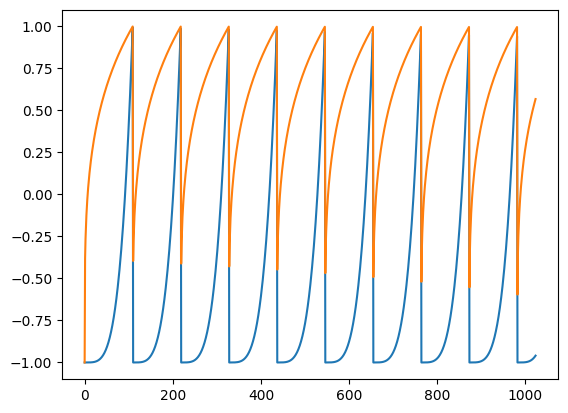

In [ ]:

freq = C(440)
s1 = Rep(freq, XP(valor=freq, pow=C(4)) * C(2) - C(1))
s2 = Rep(freq, XP(valor=freq, pow=C(1/4)) * C(2) - C(1))
# s2 = Rep(C(440), XP(valor=C(440), pow=C(2)) * C(2) - C(1), phase=Sine(C(440)))
s3 = Sawtooth(freq, phase=C(np.pi/2))
showOsc(s1, 1, True)
showOsc(s2, 1, True)
# showOsc(s3, 1, True)
input = s1

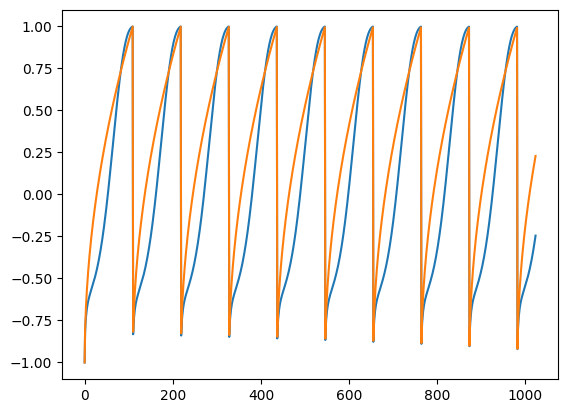

In [ ]:
freq = C(440)
s1 = Rep(freq, XP(valor=freq, pow=Sine(freq / C(1.5), min=C(0))) * C(2) - C(1)) # * C(2) - C(1) es para que vaya de -1 a 1 
s2 = Rep(freq, XP(valor=freq, pow=C(1/2)) * C(2) - C(1))
s3 = Sawtooth(freq, phase=C(np.pi/2))
showOsc(s1, 1, True)
showOsc(s2, 1, True)
# showOsc(s3, 1, True)
input = s1